In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy.io as sio

In [2]:
mat = sio.loadmat('D:\机器学习——Andrew_rag\code\ex7-kmeans and PCA\data\ex7data2.mat')
# mat.keys()
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Nov 16 00:48:22 2011', '__version__': '1.0', '__globals__': [], 'X': array([[ 1.84207953,  4.6075716 ],
       [ 5.65858312,  4.79996405],
       [ 6.35257892,  3.2908545 ],
       [ 2.90401653,  4.61220411],
       [ 3.23197916,  4.93989405],
       [ 1.24792268,  4.93267846],
       [ 1.97619886,  4.43489674],
       [ 2.23454135,  5.05547168],
       [ 2.98340757,  4.84046406],
       [ 2.97970391,  4.80671081],
       [ 2.11496411,  5.37373587],
       [ 2.12169543,  5.20854212],
       [ 1.5143529 ,  4.77003303],
       [ 2.16979227,  5.27435354],
       [ 0.41852373,  4.88312522],
       [ 2.47053695,  4.80418944],
       [ 4.06069132,  4.99503862],
       [ 3.00708934,  4.67897758],
       [ 0.66632346,  4.87187949],
       [ 3.1621865 ,  4.83658301],
       [ 0.51155258,  4.91052923],
       [ 3.1342801 ,  4.96178114],
       [ 2.04974595,  5.6241395 ],
       [ 0.66582785,  5.24399257],
       [ 1.0173201

In [3]:
data2 = pd.DataFrame(mat['X'], columns=['x1', 'x2'])
print(data2.head())

         x1        x2
0  1.842080  4.607572
1  5.658583  4.799964
2  6.352579  3.290854
3  2.904017  4.612204
4  3.231979  4.939894


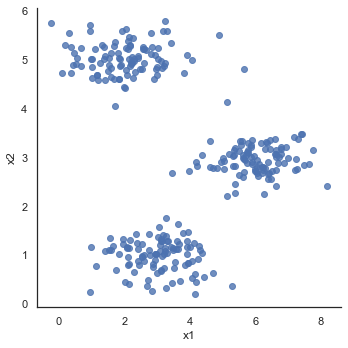

In [4]:
sns.set(context="notebook", style="white")
sns.lmplot(x='x1', y='x2',data=data2, fit_reg=False)
plt.show()

# 寻找最近质心

In [5]:
def findclosetcentroids(x, centroids):
    idx =[]
    for i in range(len(x)):
        minus = x[i] - centroids #X[i]是(1,2),然而centroids是三个点即(3,2),这里做减法的话X直接自动变成三行再减，结果是(3,2)
        dist = minus[:,0]**2 + minus[:,1]**2 #(x,y)值分别平方，将(3,2)的每行求平方和，生成一维含三个数的array，这三个数是分别到三个中心的平方和
        ci = np.argmin(dist) #获取dist最小值的索引，即哪个中心离该样本最近
        idx.append(ci)
    return np.array(idx) #最后输出一个array，里面是这所有的训练集的点分别离哪个中心最近

In [6]:
init_centroids = np.array([[3,3], [6,2], [8,5]]) #随便定义三个中心
idx = findclosetcentroids(mat['X'], init_centroids)
print(idx[0:3])

[0 2 1]


* 计算质心平均值

In [7]:
def compute_centroid_means(x, idx):
    centroids = []
    for i in range(len(np.unique(idx))): #unique是去除重复数字，并排序输出
        u_k = x[idx==i].mean(axis=0)
        centroids.append(u_k)
    return np.array(centroids)

In [8]:
compute_centroid_means(mat['X'], idx)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

In [9]:
def plot_data(x, centroids, idx=None):
    colors = ['b','g','gold','darkorange','salmon','olivedrab', 
              'maroon', 'navy', 'sienna', 'tomato', 'lightgray', 'gainsboro',
             'coral', 'aliceblue', 'dimgray', 'mintcream', 'mintcream']
    assert len(centroids[0]) <= len(colors), 'colors not enough'

    subx = []
    if idx is not None:
        for i in range(centroids[0].shape[0]):
            xi = x[idx == i]
            subx.append(xi)
    else:
        subx = [x]
    
    plt.figure(figsize=(8,5))
    for i in range(len(subx)):
        xx = subx[i]
        plt.scatter(xx[:,0], xx[:,1], c=colors[i], label='Cluster %d'%i)
    plt.legend()
    plt.grid(True)
    plt.xlabel('x1', fontsize=14)
    plt.ylabel('x2', fontsize=14)
    plt.title('Plot of x points', fontsize=16)
    xx, yy = [], []
    for centroid in centroids:
        xx.append(centroid[:,0])
        yy.append(centroid[:,1])
    
    plt.plot(xx, yy, 'rx--', markersize=8)
    plt.show()

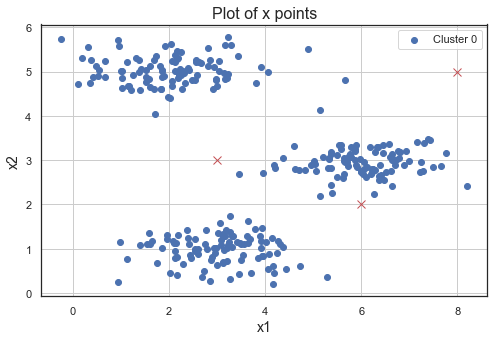

In [10]:
plot_data(mat['X'], [init_centroids])

* 寻找最优K

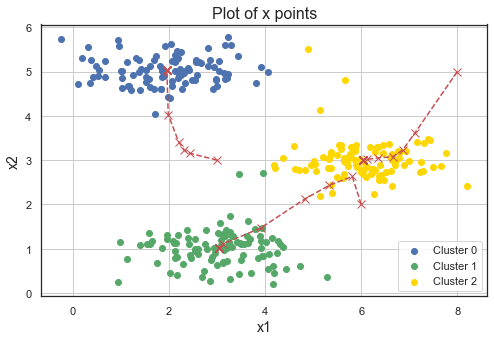

In [11]:
def runKmeans(x, centroids, max_iters):
    k = len(centroids)
    centroids_all = []
    centroids_all.append(centroids)
    for i in range(max_iters):
        idx = findclosetcentroids(x, centroids)
        centroids = compute_centroid_means(x, idx)
        centroids_all.append(centroids)
    
    return idx, centroids, centroids_all

idx, _, centroids_all = runKmeans(mat['X'], init_centroids, 20)
plot_data(mat['X'], centroids_all, idx)

* 中心点选择

In [12]:
def initcentroids(x, k):
    m = len(x)
    idx = np.random.choice(m,k)
    centroids = x[idx]
    return centroids

* 决定聚类数K

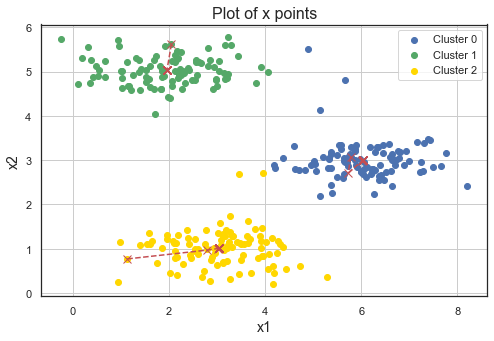

In [13]:
def find_best_key(n, x, k):
    min = 10000
    for i in range(n):
        centroids = initcentroids(x, k)
        idx, _, centroids_all = runKmeans(x, centroids, 50)
        centroid = centroids_all[50]
        sum = 0
        for i in range(k):
            subtraction = x[idx==i] - centroid[i]
            sum = sum + (subtraction**2).sum()
        if sum < min:
            min = sum
            idx_best = idx
            centroids_all_best = centroids_all
    return centroids_all_best, idx_best

centroids_all, idx = find_best_key(30, mat['X'], 3)
plot_data(mat['X'], centroids_all, idx)

In [14]:
import scipy.optimize as opt
#from skimage import io
from PIL import Image
from pylab import *
# import k_means

In [15]:
img = array(Image.open('D:\\机器学习——Andrew_rag\\code\\ex7-kmeans and PCA\\data\\bird_small.png'))
image = sio.loadmat('D:\\机器学习——Andrew_rag\\code\\ex7-kmeans and PCA\\data\\bird_small.mat')
print(image.keys())

dict_keys(['__header__', '__version__', '__globals__', 'A'])


Text(0.5, 1.0, 'Original Image')

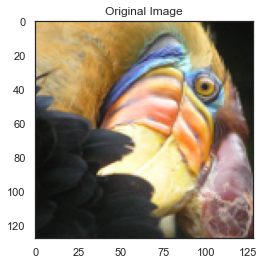

In [16]:
A = image['A']
plt.imshow(img)
plt.title('Original Image')

In [17]:
from skimage import io
A = io.imread('D:\\机器学习——Andrew_rag\\code\\ex7-kmeans and PCA\\data\\bird_small.png') / 255 #数据归一化
x = A.reshape(128*128, 3)

* K-means 压缩

In [18]:
# def findclosetcentroids_img(x, centroids):
#     idx =[]
#     for i in range(len(x)):
#         minus = x[i] - centroids #X[i]是(1,2),然而centroids是三个点即(3,2),这里做减法的
#         dist = minus[:,0]**2 + minus[:,1]**2 + minus[:,2]**2#将(3,2)的每行求平方和，生成一维含三个数的
#         ci = np.argmin(dist) #获取dist最小值的索引，即哪个中心离该样本最近
#         idx.append(ci)
#     return np.array(idx) #最后输出一个array，里面是这所有的训练集的点分别离哪个中心最近

In [19]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=16, n_init=100)

(16, 3)
(16384,)


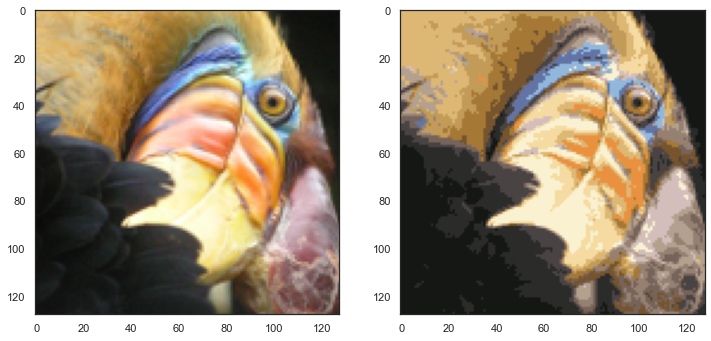

In [20]:
# centroids = initcentroids(x, 16)
# idx, _, centroids_all = runKmeans(x, centroids, 10)
# 
# img = np.zeros(x.shape)
# centroids = centroids_all[-1]
# for i in range(len(centroids)):
    # img[idx==1] = centroids[i]
model.fit(x)
centroids = model.cluster_centers_
print(centroids.shape)

c = model.predict(x)
print(c.shape)
centroids[c].shape

img = centroids[c].reshape((128, 128, 3))
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(image['A'])
ax[1].imshow(img)
plt.show()